MNIST 데이터 세트 & 데이터 로더 구성

In [1]:
from torchvision import datasets # 예제 데이터 세트
from torchvision.transforms import ToTensor # 이미지 증강(Augmentation). ToTensor -> Torch Tensor로로 만들어 주는 작업
from torch.utils.data import DataLoader # 모델에 데이터를 공급하는 역할


In [33]:
train_data = datasets.MNIST(
    root='data', # 데이터를 저장할 root 디렉토리
    train=True, # 훈련용 데이터 설정
    download=True, # 다운로드
    transform=ToTensor() # transform : 이미지 증강 기법 지정. 여기서는 단순하게 TorchTensor로 변환시킨다
)


test_data = datasets.MNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor()
) 

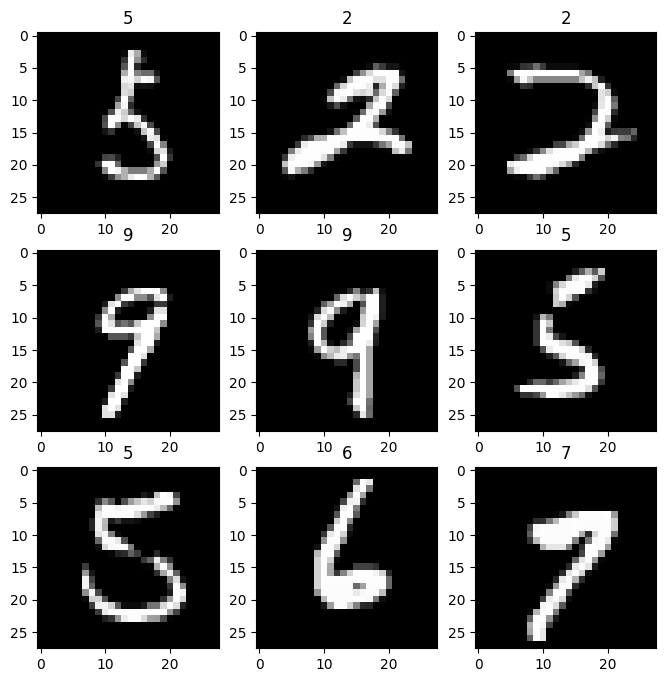

In [34]:
import torch
import matplotlib.pyplot as plt

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3

for i in range(1, cols * rows + 1):
  sample_idx = torch.randint(len(train_data), size=(1, )).item()
  feature, label = train_data[sample_idx]
  figure.add_subplot(rows, cols, i)
  plt.title(label)
  plt.imshow(feature.squeeze(), cmap='gray')

plt.show()

# PyTorch Modeling
- 파이토치는 대부분 서브 클래싱을 활용한 모델링을 수행합니다.
   - `torch.nn.Module` 클래스를 상속받아 만든다.
- 필수적으로 오버라이딩 할 메소드는 `__init__`, 순전파를 담당하는 `forward`

In [35]:
from torch import nn # 딥러닝에 필요한 레이어 패키지

class NeuralNetwork(nn.Module):

  # 사용할 레이어 또는 블록을 정의하는 공간
  def __init__(self):
    super(NeuralNetwork, self).__init__()

    self.flatten = nn.Flatten()

    # 여러 레이어가 하나의 단위로 묶이는 블록을 만들기 위해선 sequential 사용
    self.linear_relu_stack = nn.Sequential(
      ## nn.Linear : Fully Connected 구조. Keras의 Dense와 같음   
      nn.Linear(in_features=28*28, out_features=128), # Keras와 달리 들어오는 데이터와 나가는 데이터를 설정 
      nn.ReLU(),
      nn.Dropout(0.2), # 과대적합 방지. 훈련 시 마다 랜덤하게 20%의 가중치를 0으로 설정하여 사용하지 않는다.
      
      nn.Linear(128,10) # 출력층. softmax를 지정하지 않는다.
    )

  def forward(self, x):
    x = self.flatten(x)
    y = self.linear_relu_stack(x)

    return y

# 모델 생성
### 파이토치를 활용해 모델 객체를 만들고 나서 어떤 장치 환경에서 훈련이나 추론을 할지 결정을 해줘야한다.
- 파이토치의 장점으로 구체적인 설정이 가능함

In [36]:
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### `cuda`가 출력되면 GPU 사용이 가능한 상태

In [37]:
model = NeuralNetwork().to(device) # CPU에서 만들어진 모델을 GPU로 옮긴다.
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [38]:
# 또는 cuda()메소드를 활용할 수 있다.
model2 = NeuralNetwork().cuda()
print(model2)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)


# CNN 모델 구성

## Output Feature Map Size
- $i$ : 입력 feature의 개수
- $o$ : 출력 feature의 수
- $k$ : kernel size
- $p$ : padding size
- $s$ : stride size

$$
o = \bigg(\frac{i+2p-k}{s}\bigg)+1
$$

실수 형태로 크기가 나오면 반드시 정수형태로 바꿔줍니다.

### 예시
- $i$ : 입력 feature의 개수 → 7
- $o$ : 출력 feature의 수 
- $k$ : kernel size → 3
- $p$ : padding size → 0
- $s$ : stride size → 1

$$
o=\bigg(\frac{7+2\times 0-3}{1}\bigg)+1=5
$$

In [69]:
class CustomConvNet(nn.Module):
  
  def __init__(self):
    super(CustomConvNet,self).__init__()

    # Feature Extraction
    self.conv_block1 = nn.Sequential(
        nn.Conv2d(in_channels=1,out_channels = 64,kernel_size = 3, stride=1,padding=1), # (C, H, W)
        nn.ReLU(),
        nn.Conv2d(in_channels=64,out_channels = 64,kernel_size = 3, stride=1,padding=1),
        nn.ReLU()
    )

    self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2) # 입력 특성 맵의 세로 가로 크기가 절반이 된다. -> 14 X 14

    self.conv_block2 = nn.Sequential(
        nn.Conv2d(in_channels=64,out_channels = 32,kernel_size = 3, stride=1,padding=1), # (C, H, W)
        nn.ReLU(),
        nn.Conv2d(in_channels=32,out_channels = 32,kernel_size = 3, stride=1,padding=1),
        nn.ReLU()
    )

    self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2) # 7 X 7

    # FCL 구현
    self.classifier = nn.Sequential(
        nn.Linear(32*7*7,512), nn.ReLU(), # Flatten 상태의 개수로
        nn.Linear(512, 256), nn.ReLU(),
        nn.Linear(256, 10)
    )

  def forward(self,x):

    # Feature Extraction
    x = self.conv_block1(x)
    x = self.maxpool1(x)

    x = self.conv_block2(x)
    x = self.maxpool2(x)

    # FCL
    x = nn.Flatten()(x) # 객체로 만들어서 함수로 사용
    y = self.classifier(x)

    return y


In [70]:
cnn_model = CustomConvNet().to(device)
print(cnn_model)

CustomConvNet(
  (conv_block1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_block2): Sequential(
    (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (classifier): Sequential(
    (0): Linear(in_features=1568, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=10, bias=True)
  )
)


# 데이터 로더 생성

In [71]:
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=False) # 테스트 데이터는 굳이 섞을 필요가 없음.성능만 볼 것이기 때문에

# 하이퍼 파라미터 선정

In [72]:
EPOCH = 10
LEARNING_RATE=1e-3

In [73]:
# Loss Function & Optimizer
loss_fn = nn.CrossEntropyLoss() # sparse_categorical_crossentropy + categorical_crossentropy, softmax를 포함하고 있음.
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=LEARNING_RATE) # 모델에서 최적화할 파라미터를 넣어준다

# model.parameters() -> 가중치, 편향, CNN입장에서는 필터. 최적화에 의해 갱신해야 할 대상

# 훈련, 테스트 루틴 정의

In [74]:
def train_loop(dataloader, model,loss_fn,optimizer):
  size = len(dataloader.dataset)

  # 모델을 훈련 모드로 설정
  model.train() # 가중치, 편향 등을 갱신 가능!

  for batch, (X,y) in enumerate(dataloader):
    # 현재 데이터(X,y)는 CPU에 존재하는 상태. 모델은 GPU에 있음
    X,y = X.to(device), y.to(device)

    # 예측 및 손실 함수 확인
    pred = model(X) # pred : 마지막 출력층의 연산 결과
    loss = loss_fn(pred, y) # Loss가 등장

    # 미분값 구하기. 역전파를 수행해서 구하기로
    optimizer.zero_grad() # 기존에 남아있던 기울기를 제거. 이전 배치의 기울기를 반영하지 않기 위함
    loss.backward() # 역전파
    optimizer.step() # 갱신(경사하강법 수행)
    
    # print(batch)
    # print(X.size(), y.size())

    # 배치가 100번 돌 때마다 화면에 출력
    if batch % 100 == 0:
      loss, current = loss.item(), batch * len(X)
      print(f"Train Loss : {loss:>7f} [ {current:>5d} / {size:>5d} ]")

# optimizer는 테스트에서 필요 없다
def test_loop(dataloader, model, loss_fn):
  size = len(dataloader.dataset)
  test_loss, correct = 0, 0

  # 테스트 할 때는 평가모드(추론모드)
  model.eval()

  # 추론 과정에서는 기울기(gradient)를 구하지않는다.
  with torch.no_grad():
    for X,y in dataloader:
      # 추론 모드에서도 GPU는 활용해야하기 때문에 데이터를 gpu환경으로 이동
      X, y = X.to(device), y.to(device)

      pred = model(X)
      test_loss += loss_fn(pred, y).item() # item() : 텐서 내에 있는 스칼라를 가져오기
      correct += (pred.argmax(1) == y).type(torch.float).sum().item() # argmax(axis=) 인덱스찾기 -> 클래스 분류
      # pred.argmax(1) == y 는 불린값이 반환. True,False
      # y는 softmax 통해 클래스로 분류된 label

  num_batches = len(dataloader)

  # 배치 별 loss값의 평균 구하기
  test_loss /= num_batches 

  # 전체 데이터의 정확도 구하기
  correct /= size

  print(f"Test Error : \n Accuracy : {(100*correct):>0.1f}%, Avg Loss : {test_loss:>8f}\n")

In [77]:
epochs = 10
for t in range(epochs):
  print(f"Epoch {t+1}\n........................")
  train_loop(train_dataloader, cnn_model, loss_fn, optimizer)
  test_loop(test_dataloader, cnn_model, loss_fn)

print("Done!")

Epoch 1
........................
Train Loss : 0.036856 [     0 / 60000 ]
Train Loss : 0.011203 [  6400 / 60000 ]
Train Loss : 0.014041 [ 12800 / 60000 ]
Train Loss : 0.053266 [ 19200 / 60000 ]
Train Loss : 0.122720 [ 25600 / 60000 ]
Train Loss : 0.066214 [ 32000 / 60000 ]
Train Loss : 0.062470 [ 38400 / 60000 ]
Train Loss : 0.010534 [ 44800 / 60000 ]
Train Loss : 0.044462 [ 51200 / 60000 ]
Train Loss : 0.021564 [ 57600 / 60000 ]
Test Error : 
 Accuracy : 99.0%, Avg Loss : 0.030581

Epoch 2
........................
Train Loss : 0.019899 [     0 / 60000 ]
Train Loss : 0.103614 [  6400 / 60000 ]
Train Loss : 0.006808 [ 12800 / 60000 ]
Train Loss : 0.103860 [ 19200 / 60000 ]
Train Loss : 0.124386 [ 25600 / 60000 ]
Train Loss : 0.016272 [ 32000 / 60000 ]
Train Loss : 0.120145 [ 38400 / 60000 ]
Train Loss : 0.006796 [ 44800 / 60000 ]
Train Loss : 0.063983 [ 51200 / 60000 ]
Train Loss : 0.034771 [ 57600 / 60000 ]
Test Error : 
 Accuracy : 99.1%, Avg Loss : 0.030839

Epoch 3
..................